In [ ]:
#!pip install wget
#!pip install nltk
#!pip install sklearn
import wget, zipfile
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
from nltk.corpus import words as ws
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import os.path as osp
from tqdm import tqdm
from joblib import Parallel, delayed
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


#Utility

In [ ]:
"""
def train_test_split(x, y, s, seed = None):
  N = x.shape[0]
  n = int(N*s)

  inds = np.random.RandomState(seed).permutation(N)

  return x[inds[:n]], y[inds[:n]], x[inds[n:]], y[inds[n:]]
"""
def cross_validation_split(n, k, seed=None):
    inds = np.random.RandomState(seed).permutation(n)
    for i in range(k):
      start = i * n//k
      end = (i+1) * n//k
      ivalidation = inds[start:end]
      itrain = np.concatenate((inds[:start], inds[end:]), axis=0)

      yield itrain, ivalidation

def kfoldCV_mod(model, data, labels, cv, vec, seed = None):
  n = data.shape[0]
 
  acc = []
  
  for itrain, ival in cross_validation_split(n,cv,seed):
    y_pred = np.array([])
    valsize = len(ival)
    splitindices = np.arange(0,valsize,100)
    splitindices = np.append(splitindices,None)

    x_train = vec.fit_transform(data[itrain]).toarray()
    x_val = vec.transform(data[ival]).toarray()
    
    for i,ind in enumerate(splitindices[:-1]):
      y_pred = np.append(y_pred, model.fit(x_train, labels[itrain]).predict(x_val[ind:splitindices[i+1]]))

    scores = evaluate_acc(labels[ival], y_pred)
    acc.append(scores)
  return np.mean(acc)

#original kfoldCV
def kfoldCV(model,data,labels,cv,seed = None):
  n = data.shape[0]
  acc = []
  for itrain,ival in cross_validation_split(n,cv,seed):
    y_pred = model.fit(data[itrain],labels[itrain]).predict(data[ival])

    scores = evaluate_acc(labels[ival], y_pred)
    acc.append(scores)
  return np.mean(acc)


#accuracy = TP+TN/(P+N)
#precision = TP/RP
#recall = TP/P
def evaluate_acc(y_true, y_pred):
  correct = np.equal(y_true,y_pred) #TP+TN
  #RP = (y_pred == max(y_true)) 

  #TP = correct*RP
  #P = (y_true == max(y_true))
  
  acc = np.sum(correct)/len(y_true)
  #prec = sum(TP)/sum(RP)
  #recall = sum(TP)/sum(P)
  #F1 = 2*(prec*recall)/(prec+recall)

  return (acc)#,prec,recall,F1)

#Get data

In [ ]:
#getting Sentiment 140 data
sentiment140 = 'trainingandtestdata.zip' if osp.isfile('trainingandtestdata.zip') else wget.download("http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip")
testcsv = 'testdata.manual.2009.06.14.csv'
traincsv = 'training.1600000.processed.noemoticon.csv'
if not (osp.isfile(testcsv) and osp.isfile(traincsv)):
  with zipfile.ZipFile(sentiment140, 'r') as zipObj:
    zipObj.extractall()
testdf = pd.read_csv(testcsv, encoding='latin-1', header=None, usecols=[0,5])
traindf = pd.read_csv(traincsv, encoding='latin-1', header=None, usecols=[0,5])
colnames = ['class', 'text']
testdf.columns = colnames
traindf.columns = colnames

In [ ]:
traindf.loc[(traindf['class'] == 4),'class'] = 1
testdf.loc[(testdf['class'] == 4),'class'] = 1

In [ ]:
testdf = testdf[testdf['class']!=2]
print(testdf)

     class                                               text
0        1  @stellargirl I loooooooovvvvvveee my Kindle2. ...
1        1  Reading my kindle2...  Love it... Lee childs i...
2        1  Ok, first assesment of the #kindle2 ...it fuck...
3        1  @kenburbary You'll love your Kindle2. I've had...
4        1  @mikefish  Fair enough. But i have the Kindle2...
..     ...                                                ...
492      1  After using LaTeX a lot, any other typeset mat...
494      0  On that note, I hate Word. I hate Pages. I hat...
495      1  Ahhh... back in a *real* text editing environm...
496      0  Trouble in Iran, I see. Hmm. Iran. Iran so far...
497      0  Reading the tweets coming out of Iran... The w...

[359 rows x 2 columns]


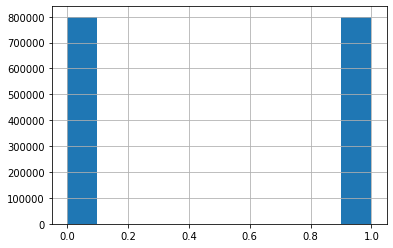

In [ ]:
traindf['class'].hist()

In [ ]:
#getting 20 newsgroups
from sklearn.datasets import fetch_20newsgroups
x_twenty_train, y_twenty_train = fetch_20newsgroups(subset='train', remove=['headers','footers','quotes'], return_X_y=True)
x_twenty_test, y_twenty_test = fetch_20newsgroups(subset='test', remove=['headers','footers','quotes'], return_X_y=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc16ad4ad0>]],
      dtype=object)

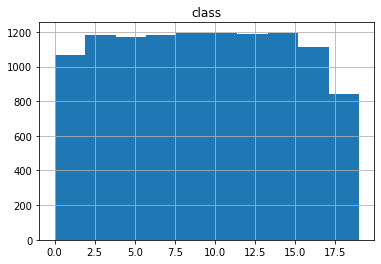

In [ ]:
train_class_df = pd.DataFrame(y_twenty_train)
train_class_df.columns = ['class']
train_class_df.hist()

#Preprocessing

In [ ]:
rstate = np.random.RandomState(1234)
traindf = traindf.sample(n=10000, random_state = rstate)

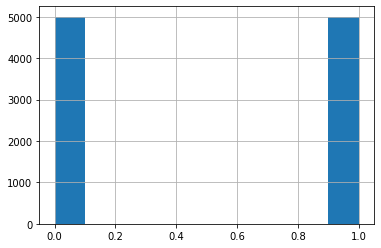

In [ ]:
traindf['class'].hist()

In [ ]:
# remove emails and headers
for i in range(len(x_twenty_train)):
  x_twenty_train[i] = x_twenty_train[i].replace('\n',' ')
  x_twenty_train[i] = re.sub(r'\W+',' ', x_twenty_train[i])
  x_twenty_train[i] = re.sub(r'\S*@\S*','', x_twenty_train[i]).replace('From article  by','')
for i in range(len(x_twenty_test)):
  x_twenty_test[i] = x_twenty_test[i].replace('\n',' ')
  x_twenty_test[i] = re.sub(r'\W+',' ', x_twenty_test[i])
  x_twenty_test[i] = re.sub(r'\S*@\S*','', x_twenty_test[i]).replace('From article  by','')

In [ ]:
# remove @, # and links
traindf['text'] = [t.replace(r'\n',' ').replace(r'#','') for t in traindf['text']]
traindf['text'] = [re.sub(r'@\S*', '', t) for t in traindf['text']]
traindf['text'] = [re.sub(r'http\S*', '', t) for t in traindf['text']]
testdf['text'] = [t.replace(r'\n',' ').replace(r'#','') for t in testdf['text']]
testdf['text'] = [re.sub(r'@\S*', '', t) for t in testdf['text']]
testdf['text'] = [re.sub(r'http\S*', '', t) for t in testdf['text']]

In [ ]:
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS
def stemTokenizer(s):
  stemmer = SnowballStemmer('english')
  words = [stemmer.stem(w) for w in word_tokenize(s) if w not in stop_words]
  return words

def lemmaTokenizer(s):
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(w) for w in word_tokenize(s) if w not in stop_words]
  return words

vect = CountVectorizer()
swvect = CountVectorizer(stop_words='english')
stemvect = CountVectorizer(tokenizer=stemTokenizer)
lemmavect = CountVectorizer(tokenizer=lemmaTokenizer)
vects = [vect,swvect,stemvect,lemmavect]

#Logistic Regression

In [ ]:
# 20news validation
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
c_values = [10, 1.0, 0.1]
grid = ParameterGrid(dict(solver=solvers, C=c_values))

besti = 0
best_params = {}
max_acc = 0
for i in range(len(vects)):
  # with Parallel(n_jobs=-1) as parallel:
  #   out = parallel(delayed(kfoldCV)(
  #       Pipeline([
  #         ('vect', vects[i]),
  #         ('tfidf', TfidfTransformer()),
  #         ('clf', LogisticRegression(multi_class = 'multinomial', random_state=999, **params)),
  #       ]), np.array(x_twenty_train), np.array(y_twenty_train), 5, seed=9999
  #   ) for params in grid)
    
  #   best_params_idx = np.argmax(out)
  #   acc = out[best_params_idx]
  #   if acc > max_acc:
  #       besti = i
  #       best_params = grid[best_params_idx]
  #       max_acc = acc

  for params in grid:
    clf = Pipeline([
          ('vect', vects[i]),
          ('tfidf', TfidfTransformer()),
          ('clf', LogisticRegression(multi_class = 'multinomial', random_state=999, **params)),
        ])
    acc = kfoldCV(clf, np.array(x_twenty_train), np.array(y_twenty_train), 5, seed=9999)
    if acc > max_acc:
        besti = i
        best_params = params
        max_acc = acc

print(f'best params: vectorizer: {vects[besti]}, {best_params}\nvalidation acc: {max_acc}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


best params: vectorizer: CountVectorizer(stop_words='english'), {'C': 10, 'solver': 'newton-cg'}
validation acc: 0.7552597371391465


final:\
best params: vectorizer: CountVectorizer(stop_words='english'), {'C': 10, 'solver': 'newton-cg'}\
validation acc: 0.7552597371391465

In [ ]:
# test set
clf = Pipeline([
    ('vect', swvect),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(multi_class = 'multinomial', random_state=999, C=10, solver='newton-cg'))
  ])
ypred = clf.fit(x_twenty_train, y_twenty_train).predict(x_twenty_test)
acc = evaluate_acc(y_twenty_test,ypred)
acc

0.6910515135422198

test acc: 0.6910515135422198

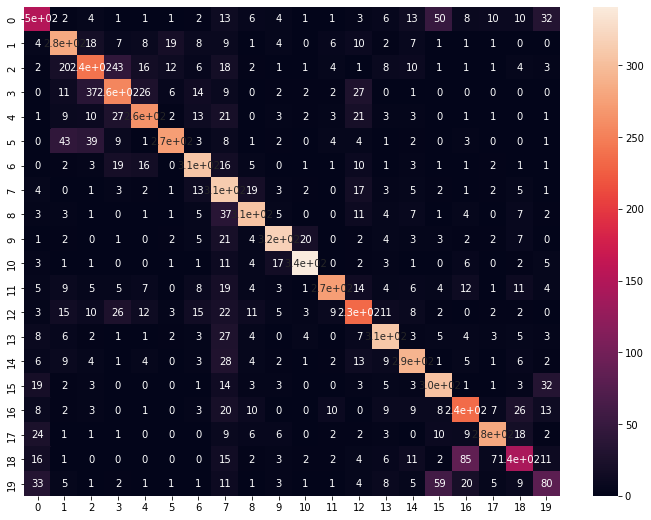

In [ ]:
plt.figure(figsize=(12, 9))
conf = confusion_matrix(y_twenty_test,ypred)
hm = sn.heatmap(conf,annot=True)
figure = hm.get_figure()    
figure.savefig('confusion_logistic_20.png')

In [ ]:
# 140 validation
solvers = ['newton-cg', 'sag', 'saga']
c_values = [10, 1.0, 0.1]
grid = ParameterGrid(dict(solver=solvers, C=c_values))

tfidftf = TfidfTransformer()
besti = 0
best_params = {}
max_acc = 0
for i in range(len(vects)):
  with Parallel(n_jobs=5) as parallel:
    out = parallel(delayed(kfoldCV)(
        Pipeline([
          ('vect', vects[i]),
          ('tfidf', TfidfTransformer()),
          ('clf', LogisticRegression(multi_class = 'multinomial', random_state=999, **params)),
        ]), traindf['text'].values, traindf['class'].values, 5, seed=9999) for params in grid)
    
    best_params_idx = np.argmax(out)
    acc = out[best_params_idx]
    if acc > max_acc:
        besti = i
        best_params = grid[best_params_idx]
        max_acc = acc

print(f'best params: vectorizer: {vects[besti]}, {best_params}\nvalidation acc: {max_acc}')

best params: vectorizer: CountVectorizer(), {'solver': 'saga', 'C': 1.0}
validation acc: 0.7464000000000001


final:\
best params: vectorizer: CountVectorizer(), {'solver': 'saga', 'C': 1.0}\
validation acc: 0.7464000000000001

In [ ]:
# test set
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(multi_class = 'multinomial', random_state=999, C=1, solver='saga'))
  ])
ypred = clf.fit(traindf['text'], traindf['class']).predict(testdf['text'])
acc = evaluate_acc(testdf['class'],ypred)
acc

0.7298050139275766

test acc: 0.7298050139275766

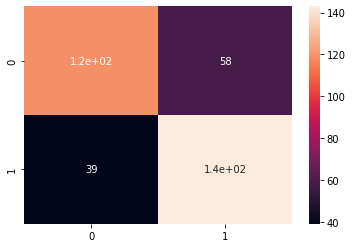

In [ ]:
conf = confusion_matrix(testdf['class'],ypred)
hm = sn.heatmap(conf,annot=True)
figure = hm.get_figure()    
figure.savefig('confusion_logistic_140.png')

# Naive Bayes

## Multinomial

In [ ]:
class MultinomialNaiveBayes:
    
    def __init__(self, alpha=1):
        self.alpha = alpha
        return
    
    def fit(self, x, y):
        n_texts, n_words = x.shape
        self.C = np.max(y) + 1

        Nc = np.zeros(self.C) #number of documents per class
        theta = np.zeros((self.C,n_words))
        for c in range(self.C):
            x_c = x[y == c] #all documents with label c
            Nc[c] = x_c.shape[0]
            total_wc = np.sum(x_c) #total word count in all documents labelled c
            theta[c] = np.sum(x_c, axis=0) #counts of each word in all documents labelled c
            theta[c] += self.alpha #laplace smoothing
            theta[c] /= total_wc + n_words * self.alpha #divided by total_wc with additive smoothing
        
        self.theta = theta #theta MLE
        self.pi = (Nc+1)/(n_texts+self.C) #prior;copied from Gaussian
        #print('Finished training.')
        return self

    def logsumexp(self, Z):                                                # dimension C x N
        Zmax = np.max(Z,axis=0)[None,:]                              # max over C
        log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
        return log_sum_exp

    def predict(self, xt):
        Nt, D = xt.shape

        log_prior = np.log(self.pi)[:, None]
        
        log_likelihood = np.log(self.theta[:,None,:]**xt[None,:,:])
        # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
        log_likelihood = np.sum(log_likelihood, axis=2)
        # posterior calculation
        log_posterior = log_prior + log_likelihood
        posterior = np.exp(log_posterior - self.logsumexp(log_posterior))


        return np.argmax(posterior.T, 1)

    

### Test (20 news groups)

In [ ]:
countvect = CountVectorizer(stop_words='english')
xtrain = countvect.fit_transform(x_twenty_train)
xtest = countvect.transform(x_twenty_test)

In [ ]:
multiNB = MultinomialNaiveBayes()
#splitting test sets due to memory issues
y_pred = np.array([])
testsize = xtest.shape[0]
splitindices = np.arange(0,testsize,100)
splitindices = np.append(splitindices,None)

for i,ind in enumerate(splitindices[:-1]):
  y_pred = np.append(y_pred, multiNB.fit(xtrain, np.array(y_twenty_train)).predict(xtest[ind:splitindices[i+1]]))


In [ ]:
accuracy = np.sum(y_pred == y_twenty_test)/y_pred.shape[0]
accuracy

### Test (140 sentiments)

In [ ]:
countvect = CountVectorizer()
xtrain = countvect.fit_transform(traindf['text']).toarray()
xtest = countvect.transform(testdf['text']).toarray()

In [ ]:
multiNB = MultinomialNaiveBayes()
y_pred = multiNB.fit(xtrain, np.array(traindf['class'])).predict(xtest)

In [ ]:
accuracy = np.sum(y_pred == testdf['class'])/y_pred.shape[0]
accuracy

## Gaussian

In [ ]:
class GaussianNaiveBayes:#copied from provided example code
    
    def __init__(self):
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        self.C=C
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
            x_c = x[y == c]                           #slice all the elements from class c
            Nc[c] = x_c.shape[0]                      #get number of elements of class c
            mu[c,:] = x_c.mean(0)                  #mean of features of class c
            sqr = x_c.copy()
            sqr.data **= 2
            sigma[c,:] = np.sqrt(sqr.mean(0) - np.square(x_c.mean(0)))               #std of features of class c
            
        self.mu = mu                                  # C x D
        self.sigma = sigma + 1e-9                     # C x D
        self.pi = (Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

    def logsumexp(self, Z):                                                # dimension C x N
        Zmax = np.max(Z,axis=0)[None,:]                              # max over C
        log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
        return log_sum_exp

    def predict(self, xt):
        Nt, D = xt.shape
        # for numerical stability we work in the log domain
        # we add a dimension because this is added to the log-likelihood matrix 
        # that assigns a likelihood for each class (C) to each test point, and so it is C x N
        log_posterior = []
        for i in range(self.C):
          log_prior = np.log(self.pi[i])
          log_likelihood = -0.5 * np.sum(np.log(2.0 * np.pi * self.sigma[i, :]))
          log_likelihood -= 0.5 * np.sum((np.asarray(xt - self.mu[i, :]) ** 2) / (self.sigma[i, :]), 1)
          log_posterior.append(log_prior + log_likelihood)
        # log_prior = np.log(self.pi)[:, None]
        # logarithm of the likelihood term for Gaussian 
        # the first two terms are the logarithm of the normalization term in the Gaussian and the final term is the exponent in the Gaussian. 
        # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation. 
        # The reason is that sigma and mu are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
        # log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
        # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
        # log_likelihood = np.sum(log_likelihood, axis=2)
        # posterior calculation
        # log_posterior = log_prior + log_likelihood
        posterior = np.exp(log_posterior - self.logsumexp(log_posterior))

        return np.argmax(posterior.T, 1) 

### Test (20 news groups) (informal)

In [ ]:
#manually experimented different vectorizers
tfidfvect = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2, tokenizer=lemmaTokenizer)
xtrain = tfidfvect.fit_transform(x_twenty_train).toarray()
xtest = tfidfvect.transform(x_twenty_test).toarray()

In [ ]:
GNB = GaussianNaiveBayes()
y_pred = GNB.fit(xtrain, np.array(y_twenty_train)).predict(xtest)

In [ ]:
accuracy = np.sum(y_pred == y_twenty_test)/y_pred.shape[0]

In [ ]:
accuracy

### Test (140 sentiments) (informal)

In [ ]:
tfidfvect = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2, tokenizer=lemmaTokenizer)
xtrain = tfidfvect.fit_transform(traindf['text']).toarray()
xtest = tfidfvect.transform(testdf['text']).toarray()

In [ ]:
GNB = GaussianNaiveBayes()
y_pred = GNB.fit(xtrain, np.array(traindf['class'])).predict(xtest)

In [ ]:
accuracy = np.sum(y_pred == testdf['class'])/y_pred.shape[0]
accuracy

## Naive Bayes model selection

### Multinomial

In [ ]:
# 140
#Manually change the arguments of CountVectorizer() to test different vectorizers 
model = MultinomialNaiveBayes

x_train = np.array(traindf['text'])
acc = kfoldCV_mod(model(), x_train, np.array(traindf['class']), 5, 
              CountVectorizer(), seed=9999)

print(f'validation acc: {acc}')

validation acc: 0.7301


CountVectorizer(), validation acc: 0.7301

In [ ]:
# 20
model = MultinomialNaiveBayes

x_train = np.array(x_twenty_train)
acc = kfoldCV_mod(model(), x_train, np.array(y_twenty_train), 5, 
              CountVectorizer(stop_words='english'), seed=9999)

print(f'validation acc: {acc}')

/home/lanxi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log
/home/lanxi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in subtract


validation acc: 0.6700554376267116


CountVectorizer(stop_words='english') acc: 0.67

### Gaussian

In [ ]:
# 140
besti = 0
max_acc = 0

for i in range(len(vects)):
  clf = Pipeline([
    ('vect', vects[i]),
    ('tfidf', TfidfTransformer()),
    ('clf', GaussianNaiveBayes()),
  ])
  acc = kfoldCV(clf, np.array(traindf['text']), np.array(traindf['class']), 5, seed=9999)
  
  if acc > max_acc:
      besti = i
      max_acc = acc
  

print(f'best params: vectorizer: {vects[besti]}\nvalidation acc: {acc}')

final:\
best params: vectorizer: CountVectorizer(stop_words='english')\
validation acc: 0.592

In [ ]:
# 20
besti = 0
max_acc = 0

for i in range(len(vects)):
  clf = Pipeline([
    ('vect', vects[i]),
    ('tfidf', TfidfTransformer()),
    ('clf', GaussianNaiveBayes()),
  ])
  acc = kfoldCV(clf, np.array(x_twenty_train), np.array(y_twenty_train), 5, seed=9999)
  
  if acc > max_acc:
      besti = i
      max_acc = acc
  

print(f'best params: vectorizer: {vects[besti]}\nvalidation acc: {max_acc}')

final:\
best params: vectorizer: CountVectorizer(stop_words='english')\
validation acc: 0.6314289029726273

# Accuracy & Training set size

In [ ]:
def trainsize(xtrain, xtest, ytrain, ytest, model):

    #randomly select part of the training set

    train_size = xtrain.shape[0]
    sizes = np.array([.2,.4,.6,.8, 1.])
    inds = np.random.RandomState(1234).permutation(train_size)
    cutoffs = np.floor(sizes*train_size).astype(int)

    accs = np.zeros(sizes.shape[0])

    for i,n in enumerate(cutoffs):
        xsub = xtrain[inds[:n]]
        ysub = ytrain[inds[:n]]

        #for multinomialNB 20NG only
        """
        y_pred = np.array([])
        testsize = len(xtest)
        splitindices = np.arange(0,testsize,100)
        splitindices = np.append(splitindices,None)

        for j,ind in enumerate(splitindices[:-1]):
            y_pred = np.append(y_pred, model.fit(xsub, ysub).predict(xtest[ind:splitindices[j+1]]))

        """

        y_pred = model.fit(xsub,np.array(ysub)).predict(xtest)

        accs[i] = evaluate_acc(ytest,y_pred)
    
    return(accs)

In [ ]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(multi_class = 'multinomial', random_state=999, C=1, solver='saga'))
  ])

In [ ]:
print(trainsize(np.array(traindf['text']),np.array(testdf['text']),np.array(traindf['class']),np.array(testdf['class']),clf))

[0.67688022 0.69359331 0.71587744 0.71866295 0.72980501]


LR 140: [0.67688022 0.69359331 0.71587744 0.71866295 0.72980501]

In [ ]:
clf = Pipeline([
    ('vect', swvect),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(multi_class = 'multinomial', random_state=999, C=10, solver='newton-cg'))
  ])
print(trainsize(np.array(x_twenty_train),np.array(x_twenty_test),np.array(y_twenty_train),np.array(y_twenty_test),clf))

[0.62201275 0.64843335 0.66622411 0.67976633]


LR 20: [0.62201275 0.64843335 0.66622411 0.67976633 0.69105151]

NB 20: [0.48353691 0.53571429 0.57580988 0.6133829 0.63276686]

NB 140: [0.67688022 0.68523677 0.71309192 0.71866295 0.73537604]

In [ ]:
LR_140 = [0.67688022, 0.69359331, 0.71587744, 0.71866295, 0.72980501]
LR_20 = [0.62201275, 0.64843335, 0.66622411, 0.67976633, 0.69105151]
NB_20 = [0.48353691, 0.53571429, 0.57580988, 0.6133829, 0.63276686]
NB_140 = [0.67688022, 0.68523677, 0.71309192, 0.71866295, 0.73537604]

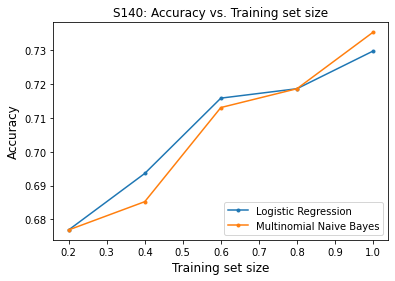

In [ ]:
plt.figure()

plt.plot([.2,.4,.6,.8, 1.], LR_140, '.-', label = 'Logistic Regression')
plt.plot([.2,.4,.6,.8, 1.], NB_140, '.-', label = 'Multinomial Naive Bayes')


plt.xlabel('Training set size',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('S140: Accuracy vs. Training set size',fontsize=12)

plt.legend(loc='lower right')
plt.savefig('S140Trainsize.png',bbox_inches='tight')
plt.show()   

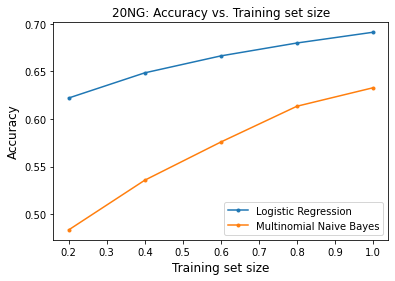

In [ ]:
plt.figure()

plt.plot([.2,.4,.6,.8, 1.], LR_20, '.-', label = 'Logistic Regression')
plt.plot([.2,.4,.6,.8, 1.], NB_20, '.-', label = 'Multinomial Naive Bayes')


plt.xlabel('Training set size',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('20NG: Accuracy vs. Training set size',fontsize=12)

plt.legend()
plt.savefig('20NGTrainsize.png',bbox_inches='tight')
plt.show()   